## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
import itertools
# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
from keras.callbacks import ModelCheckpoint
"""
Set model checkpoint callbacks
Write your training loop and show the results
"""
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)


In [9]:
from keras.callbacks import ReduceLROnPlateau
results={}
for i in range(5,0,-1):
    keras.backend.clear_session()
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    reduce_lr = ReduceLROnPlateau(factor=0.1 * i, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=i, 
                              verbose=1)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    tag = "factor:%s, patience:%s"%(0.1 * i,i)
    results[tag] = {"train_loss":train_loss,"valid_loss":valid_loss,"train_acc":train_acc, "valid_acc":valid_acc}
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 1s 13us/step - loss: 0.7983 - acc: 0.7469 - val_loss: 1.4578 - val_acc: 0.5084
Epoch 48/50
50000/50000 [==============================] - 1s 14us/step - loss: 0.7971 - acc: 0.7462 - val_loss: 1.4582 - val_acc: 0.5080
Epoch 49/50
50000/50000 [==============================] - 1s 14us/step - loss: 0.7963 - acc: 0.7471 - val_loss: 1.4582 - val_acc: 0.5077
Epoch 50/50
50000/50000 [==============================] - 1s 13us/step - loss: 0.7957 - acc: 0.7470 - val_loss: 1.4594 - val_acc: 0.5078
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048     

50000/50000 [==============================] - 1s 13us/step - loss: 0.9073 - acc: 0.7034 - val_loss: 1.4519 - val_acc: 0.4991

Epoch 00043: ReduceLROnPlateau reducing learning rate to 4.09600033890456e-06.
Epoch 44/50
50000/50000 [==============================] - 1s 13us/step - loss: 0.9061 - acc: 0.7020 - val_loss: 1.4520 - val_acc: 0.4992
Epoch 45/50
50000/50000 [==============================] - 1s 14us/step - loss: 0.9065 - acc: 0.7027 - val_loss: 1.4521 - val_acc: 0.4996
Epoch 46/50
50000/50000 [==============================] - 1s 14us/step - loss: 0.9066 - acc: 0.7022 - val_loss: 1.4521 - val_acc: 0.5001
Epoch 47/50
50000/50000 [==============================] - 1s 14us/step - loss: 0.9066 - acc: 0.7020 - val_loss: 1.4521 - val_acc: 0.5000

Epoch 00047: ReduceLROnPlateau reducing learning rate to 1.6384001355618238e-06.
Epoch 48/50
50000/50000 [==============================] - 1s 13us/step - loss: 0.9066 - acc: 0.7029 - val_loss: 1.4521 - val_acc: 0.4995
Epoch 49/50
50000/5000

50000/50000 [==============================] - 1s 14us/step - loss: 0.8932 - acc: 0.7056 - val_loss: 1.4557 - val_acc: 0.5034
Epoch 39/50
50000/50000 [==============================] - 1s 14us/step - loss: 0.8936 - acc: 0.7057 - val_loss: 1.4556 - val_acc: 0.5033
Epoch 40/50
50000/50000 [==============================] - 1s 14us/step - loss: 0.8931 - acc: 0.7062 - val_loss: 1.4557 - val_acc: 0.5030

Epoch 00040: ReduceLROnPlateau reducing learning rate to 7.289999985005125e-07.
Epoch 41/50
50000/50000 [==============================] - 1s 14us/step - loss: 0.8931 - acc: 0.7055 - val_loss: 1.4557 - val_acc: 0.5033
Epoch 42/50
50000/50000 [==============================] - 1s 14us/step - loss: 0.8930 - acc: 0.7062 - val_loss: 1.4557 - val_acc: 0.5034
Epoch 43/50
50000/50000 [==============================] - 1s 13us/step - loss: 0.8930 - acc: 0.7060 - val_loss: 1.4557 - val_acc: 0.5031

Epoch 00043: ReduceLROnPlateau reducing learning rate to 2.1870000637136403e-07.
Epoch 44/50
50000/500

Epoch 32/50
50000/50000 [==============================] - 1s 13us/step - loss: 1.0355 - acc: 0.6514 - val_loss: 1.4463 - val_acc: 0.4968

Epoch 00032: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.
Epoch 33/50
50000/50000 [==============================] - 1s 13us/step - loss: 1.0358 - acc: 0.6513 - val_loss: 1.4463 - val_acc: 0.4967
Epoch 34/50
50000/50000 [==============================] - 1s 14us/step - loss: 1.0359 - acc: 0.6507 - val_loss: 1.4463 - val_acc: 0.4968

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1.2800001059076749e-08.
Epoch 35/50
50000/50000 [==============================] - 1s 13us/step - loss: 1.0353 - acc: 0.6525 - val_loss: 1.4463 - val_acc: 0.4966
Epoch 36/50
50000/50000 [==============================] - 1s 13us/step - loss: 1.0356 - acc: 0.6515 - val_loss: 1.4464 - val_acc: 0.4965

Epoch 00036: ReduceLROnPlateau reducing learning rate to 2.5600002118153498e-09.
Epoch 37/50
50000/50000 [==============================] - 1s 13u

50000/50000 [==============================] - 1s 12us/step - loss: 1.1122 - acc: 0.6214 - val_loss: 1.4517 - val_acc: 0.4943

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 25/50
50000/50000 [==============================] - 1s 13us/step - loss: 1.1121 - acc: 0.6201 - val_loss: 1.4515 - val_acc: 0.4936

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 26/50
50000/50000 [==============================] - 1s 13us/step - loss: 1.1127 - acc: 0.6210 - val_loss: 1.4515 - val_acc: 0.4938

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
Epoch 27/50
50000/50000 [==============================] - 1s 13us/step - loss: 1.1117 - acc: 0.6196 - val_loss: 1.4515 - val_acc: 0.4937

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.
Epoch 28/50
50000/50000 [==============================] - 1s 13us/step - loss: 1.1113 - acc: 0.6210 - val_loss: 1.4515 - val_acc: 0.49

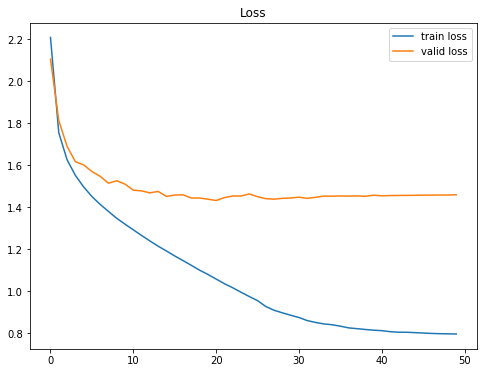

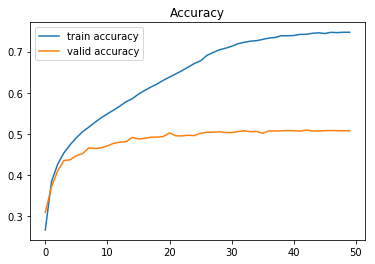

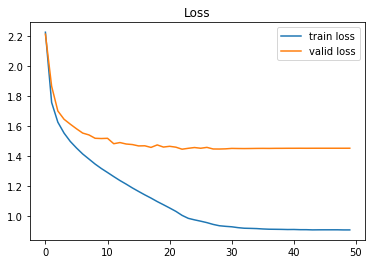

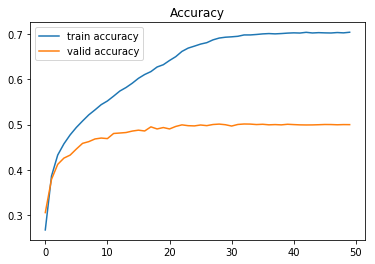

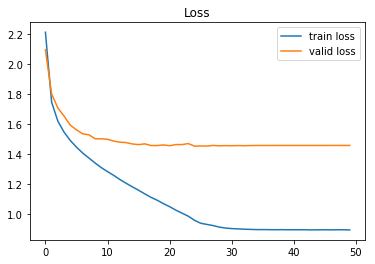

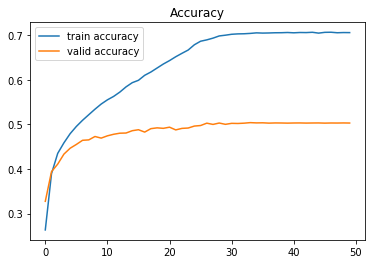

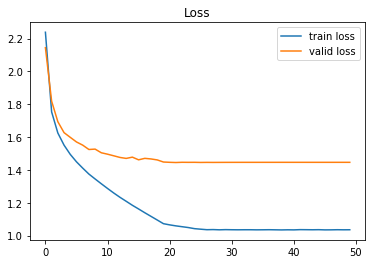

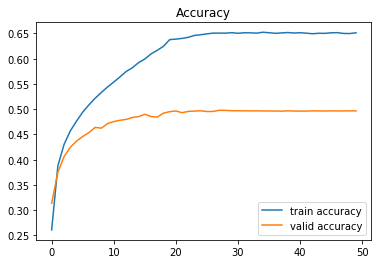

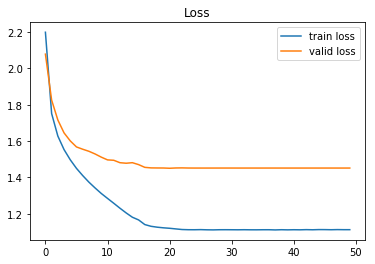

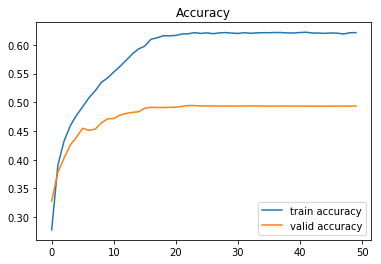

In [11]:
# 繪製結果
"""
plot the results
"""
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]["train_loss"])), results[cond]["train_loss"], label="train loss")
    plt.plot(range(len(results[cond]["valid_loss"])), results[cond]["valid_loss"], label="valid loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

    plt.plot(range(len(results[cond]["train_loss"])), results[cond]["train_acc"], label="train accuracy")
    plt.plot(range(len(results[cond]["valid_loss"])), results[cond]["valid_acc"], label="valid accuracy")
    plt.legend()
    plt.title("Accuracy")
    plt.show()